# DNA Sequence Comparison
__October, 2018 - Christopher Sanchez__ 

A neuroevolution model will be created in order to compare DNA sequences. A genetic algorithm will be used to train a recurrent neural network to best determine similarity between sequences. The genetic algorithm will be utilized to determine the best weighting of the networks. The goal today is for the network to be effective at predicting similarity in order to infer homogeneity

Deoxyribonucleic acid, or DNA is a double helix shaped structure consisting of a chain of nucleotides known as basepairs that act like a blueprint, providing a list of instructions for your body to create proteins. There are four distinct bases A, T, C and G. A always bonds with T and C always bonds with G. A wide variety of information can be gained from DNA analysis. It is possible to determine gender, disease susceptibility, familial ties, DNA is responsible for solving countless amounts of crime, and more! There are multiple sequencing techniques out there, but not all are great for error. I was inspired by this paper: https://www.cse.unr.edu/~cheung/neorgene.pdf, to attempt improving the dna sequencing techniques that are used today. There will be two genes used today one for training which is LOCUS NT_187300, and is 156,246 base pairs long. The other gene that will be used for testing is LOCUS NT_187301 and is 177,312 basepairs long. A LSTM RNN is perfect for the task, because it works well with error. A human genome consists of six billion basepairs mistakes are going to be made. It isn't uncommon for a basepair to get switched around. It is important to use a technique that can operate quickly and accurately. 

Genetic algorithms work by immitating Darwin's survival of the fittest theory. The survival of the fittest theory suggests that natural selection selects the best individuals and discards the weakest, thereby passing on only the strognest genes. Each sample is considered an individual. A population is all of the individuals together. A fitness score is used to determine how fit or weak an individual is. The best parents are used to breed and create individuals with characteristics of the parents. A mutation can be added to further improve on results. Finally evolution takes place combining all of the steps together to create the best offspring possible.

Combining recurrent neural networks and a genetic algorithm is a quite interesting way to train the network. First the dna sequence must be cleaned and processed in order to be passed into the neural network. Once the sequence is processed and split into individuals the genetic algorithm will pass the individuals into the neural network using mean squared error as the fitness score in order to provide a grade to each network. Then the data will be bred and mutated in order to produce offspring and cause evolution.

In [1]:
import numpy as np
import pandas as pd
import re
from operator import add, sub
from numpy import argmax, array
from collections import Counter
import matplotlib.pyplot as plt
import keras
import tensorflow
# Import various componenets for model building
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM, Input, TimeDistributed, SimpleRNN
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error
from scipy.stats import bernoulli
# Import the backend
from keras import backend as K
from keras.preprocessing.sequence import pad_sequences


/Users/c/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/Users/c/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


This total similarity function will be used to determine a similarity score for the tested data to compare with the output from the network.

In [2]:
def total_similarity(similarity):
    unique, counts = np.unique(similarity, return_counts=True)
    total_similarity = dict(zip(unique, counts))
    if False not in total_similarity:
        total_similarity[False] = 0

    if total_similarity[True] and total_similarity[False] > 0:
        total_similarity = total_similarity[True].sum() / (total_similarity[False] + total_similarity[True])
    elif total_similarity[False] == 0:
        total_similarity = 1.0
    else:
        total_similarity = 0.0
    return total_similarity

The mean squared error will act as a fitness function, and will also be useful for determining the accuracy of the network.

In [3]:
def mse(y_true, y_pred):
    y_true = y_true.reshape(y_true.shape[0], y_true.shape[1])
    y_pred = y_pred.reshape(y_pred.shape[0], y_pred.shape[1])
    mse = mean_squared_error(y_true, y_pred)
    return mse

The below two functions will be used to create bargraphs in a more presentable way.

In [4]:
def basepair_graph(data):
    character_count = Counter(data)

    labels, values = zip(*character_count.items())

    indexes = np.arange(len(labels))
    width = .8

    plt.bar(indexes, values, width)
    plt.xticks(indexes + width * 0, labels)
    plt.title('Count of Basepairs')
    plt.xlabel('Basepairs')
    plt.ylabel('Count')
    plt.show()

def basepair_graph_comparison(sequence_one, sequence_two, width, ax=None):
    sequence_one_count = Counter(sequence_one)
    sequence_two_count = Counter(sequence_two)

    labels_one, values_one = zip(*sequence_one_count.items())
    labels_two, values_two = zip(*sequence_two_count.items())

    indexes = np.arange(len(labels_one))

    ax.bar(indexes, values_one, width);
    ax.bar(indexes, values_two, width * .5);


### I: Importing and analyzing data
The dna sequences contain numbers labeling the lines, multiple new lines and some whitespaces. The sequence is cleaned, and then a bar graph is used to show the distribution of the individual basepairs.

In [5]:
with open('dna.txt', 'r') as myfile:
  dna = myfile.read()
dna_basepairs = dna
dna_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', dna_basepairs)
dna_basepairs = re.sub(r'\n', '', dna_basepairs)
dna_basepairs = re.sub(r'\s+', '', dna_basepairs).strip()

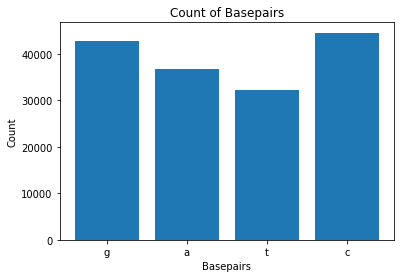

In [6]:
basepair_graph(dna_basepairs)

The amount of basepairs are pretty close. C's and G's have the most, with T having the least. Overall it is a pretty nice distribution to work with.

### II: Processing the Dna Sequence into an array and determining similarity

The two sequences that need to be compared, and the split size are passed into the create_dna_array function. The amount of timesteps and samples are calculated in order to properly reshape the data to be passed into the neural networks. An array of zeroes is created to provide an array to be manipulated and allow for vectorization of the base pairs. The array will be shuffled to help prevent overfitting of the neural network. The two sequences will be vectorized and combined in order to be tested for similarity. Finally a similarity score will be awarded to each pair of sequences. 

In [7]:
def create_dna_array(sequence_one, sequence_two, timesteps):

    # timesteps and samples to determine reshape size
    timesteps = timesteps
    samples = int(len(sequence_one) / timesteps)
    
    # Create an array of zeros to be manipulated
    array = np.zeros((len(sequence_one),8))
    
    # mutating the array to effectively vectorize the basepairs.
    vectorize_sequence = {'a': 1, 't': 2, 'g': 3, 'c': 4}
    
    for base in range(len(sequence_one)):
        base_one = sequence_one[base]
        base_two = sequence_two[base]
        array[base, vectorize_sequence[base_one]] = 1
        array[base, vectorize_sequence[base_two] + 3] = 1
    # shuffle the array to help prevent overfitting
    np.random.shuffle(array)
    # determine whether sequences are similar or not
    similarity_array = np.zeros((len(array),1))
    similarity_array = np.asarray([similarity_array[i] == 1 
                                   if np.equal(array[i, :4], array[i, 4:]).all() 
                                   else similarity_array[i] == 0 
                                   for i in range(len(array))])
    
    return np.asarray(array).reshape(samples, timesteps, 8), similarity_array.reshape(samples, timesteps, 1)

### III: Creating the population of LSTM networks

30 LSTM networks, which will be considered the individuals in this test, will be created as the population. The network consists of three layers. The input layer, an LSTM layer, and a dense layer as the output layer. A tanh function will be used which will give an output between -0.9 and 0.9. 0.9 will be interpreted as having a very high similarity and -0.9 will be the inverse. Bias will also be used. 

In [8]:
def create_population(comparison):
    network_population = []
    for i in range(30):
        model = Sequential()
        # add Long short term memory RNN and a dense layer. Compile the model
        model.add(LSTM(10, 
                       input_shape=(comparison.shape[1],8), 
                       activation='tanh', 
                       return_sequences=True, 
                       use_bias=True))
        model.add(Dense(1, 
                        activation='tanh', 
                        use_bias=True))
        network_population.append(model)
    return network_population

### IV: Grading the population:

The grading function is used to grade the fitness scores of the networks in order to sort the fittest networks from the weakest. For each individual in the population a prediction will be made using the individual network and scored using mean squared error. The networks will then be sorted using argsort. Finally the networks will be split into the nth fittest and weakest models. 

In [9]:
def grade(pop, inputs, labels, split):
    # mse_vec stores the mean squared error score for each network in the population
    mse_vec = []
    for i in pop:
        # make a prediction with each individual
        y_pred = i.predict(inputs)
        # calculate mean squared error
        m_s_e = mse(labels, y_pred)
        # keep track of epochs
        mse_vec.append(m_s_e)
    # convert mse_vec list to array
    mse_vec = np.asarray(mse_vec)

    # arg sort MSE separate the fittest networks from the weakest.
    sorted_mse_idx = np.argsort(mse_vec)
    
    # set split to allow for various splits
    fittest_mse = sorted_mse_idx[:split]
    weakest_mse = sorted_mse_idx[split:]

    # separate the fittest networks from the weakest.
    fittest_models = []
    weakest_models = []

    for model in fittest_mse:
        fittest_models.append(network_population[model])
    for model in weakest_mse:
        weakest_models.append(network_population[model])
    return [fittest_models, weakest_models]

### V: Crossover and Mutate

The crossover function is to represent breeding of fit individuals. Simulating reproduction, the fittest individuals will be bred with the weakest individuals, producing offspring with traits from each of the parent individuals. The children will be used to set the new weights for the weakest individuals.

In [10]:
def crossover(fittest, weakest, rate):
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()
    boolean_weights = []
    # randomly select index's of array to be replaced
    for layer in fittest_weights:
        boolean_weights.append(bernoulli.rvs(rate, size=layer.shape))
    #select weights to take from fittest weights
    select_fittest = [random_layer * network_layer + random_layer for 
                      random_layer, network_layer in zip(boolean_weights, fittest_weights)]
    # select weakest weights to kill off
    kill_weakest = [(1 - random_layer) * network_layer for 
                    random_layer, network_layer in zip(boolean_weights, weakest_weights)]
    # create the new array of weights by combining the weights from the fittest individuals with
    #the weights from the weakest individuals
    child_weights = [kill_weakest_layer + select_fittest_layer for 
                     kill_weakest_layer, select_fittest_layer in zip(select_fittest, kill_weakest)]
    
    weakest.set_weights(child_weights)

Mutate is used to emulate a mutation in the wild. All of the weights will either be summed or subtracted with a value from a gaussian distribution.

In [11]:
def mutate(fittest, weakest, rate):
    # get weights
    fittest_weights = fittest.get_weights()
    weakest_weights = weakest.get_weights()
    # addition and subtraction operators
    operators = (add, sub)
    
    # add a random value from a gaussian distributions to the previous weights
    for layer in fittest_weights:
        operate = np.random.choice(operators)
        # select percentage of weights to modify
        select_weights = bernoulli.rvs(p=rate, size=layer.shape)
        # generate gaussian distribution
        random_numbers = np.random.normal(0, 1, layer.shape)
        layer[select_weights==1] = operate(random_numbers[select_weights==1], layer[select_weights==1])
        
    for layer in weakest_weights:
        operate = np.random.choice(operators)
        select_weights = bernoulli.rvs(p=0.5, size=layer.shape)
        random_numbers = np.random.normal(0, 1, layer.shape)
        layer[select_weights==1] = operate(random_numbers[select_weights==1], layer[select_weights==1])
        
    # set the new weights
    fittest.set_weights(fittest_weights)
    weakest.set_weights(weakest_weights)


### VI Breeding

The breeding function will be used to carry out the simulation of breeding the individuals. For each of the weakest individuals a fit model will be chosen, then the crossover will take place, followed by the mutation. Finally A new child population will be born.

In [12]:
def breed(fittest, weakest, rate):
    for weakest_model in weakest:
        #choose random model to take weights from
        fittest_model = np.random.choice(fittest)
        #crossover weights
        crossover(fittest_model, weakest_model, rate)
        # add or subtract weight from a gaussian distribution
        mutate(fittest_model, weakest_model, rate)    
        network_pop = fittest + weakest
    return network_pop

### VII: Evolve

Tying all of the steps together, evolution will take place. First the initial population is generated. The network is then graded and passed through the breeding function, which crosses and mutates the individuals. The children are then set as the new network population. This process will be repeated 30 times and 150 epochs each. The first run will allow for various mutation rates. The first run will also allow for different splits of the fittest and weakest individuals. Each subsequent run will be set at a mutation rate of 50% and the amount of fit networks to keep will be set to 10. After the evolution process has finished, the results will be visualized and analyzed.

In [ ]:
# set the network population to the original generated network population
network_population = []
graph_mse = []
mutate_rate = []
split_rate = []
for run in range(30):
    # set mutation rate to 50% and split rate to the 10th index
    rate = .5
    split = 9
    # create the data shuffling it each run.
    comparison, similarity_array = create_dna_array(dna_basepairs[:150000], dna_basepairs[5000:155000], 100)
    
    # create the initial population
    if run == 0:
        network_population = create_population(comparison)
    else:
        pass
    
    # run 150 epochs
    for epoch in range(149):
        # grade the network population and breed it

        grade_network = grade(network_population, comparison, similarity_array, split)
        breed_networks = breed(grade_network[0],grade_network[1],rate)
        # set the network population to the new offspring
        network_population = breed_networks

        # add the top network score to a list for each epoch to be plotted
        y_pred = network_population[0].predict(comparison)
        m_s_e = mse(similarity_array, y_pred)
        graph_mse.append(m_s_e)
        print(m_s_e)
        
        # for the first run and every 10th epoch select a random mutation and split rate
        if run == 0 and epoch % 10:
            rate = np.random.choice(np.arange(0.1, 0.9, .1))
            split = np.random.choice(np.arange(5, 25, 1))
            mutate_rate.append(rate)
            split_rate.append(split)
            
    # for every 5 runs print run
    if run % 5:
        print(run)

# graph the Mean Squared error of the top networks through each epoch.
plt.plot(graph_mse)
plt.title('Mean Squared Error')
plt.xlabel('x')
plt.ylabel('y')
plt.show()


0.876627
0.22868812
1.2792648
0.43977252
0.3658277
3.3201003
1.6148838
0.18470387
1.8118738
0.18484978
0.18479116
0.18479116
0.18465653


"" Some text about how the graph looks and how the network performed "" 

The output of the best network will be visualized for analysis. 

In [ ]:
# run the best network on the test data to test for consistency.
y_pred = network_population[0].predict(comparison)
m_s_e = mse(similarity_array, y_pred)

print(y_pred.mean())
print('Total Similarity:', total_similarity(similarity_array))
print('Mean Squared Error:', m_s_e)

# graph the output similarity of the top network.
plt.figure(figsize=(20,2))
plt.plot(y_pred.reshape(y_pred.shape[0]*y_pred.shape[1], 1))
plt.title('Similarity Output')
plt.xlabel('Count')
plt.ylabel('Similarity')
plt.show()

"" analysis of the graph ""

### VIII: Importing test sequence
The test DNA sequence will be passed in and cleaned and visualized as it was previously, removing the numbers, new lines, and whitespaces.

In [ ]:
with open('dna2.txt', 'r') as myfile:
  dna2 = myfile.read()
test_basepairs = dna2
test_basepairs = re.sub(r'[0-9]([0-9])?([0-9])?([0-9])?([0-9])?([0-9])?', '', test_basepairs)
test_basepairs = re.sub(r'\n', '', test_basepairs)
test_basepairs = re.sub(r'\s+', '', test_basepairs).strip()

In [ ]:
basepair_graph(test_basepairs)

### IX: Processing the data for testing
The DNA sequence will be split into four different sets of sequences. The similarity will be variable and will be a good gauge of how the model is performing. The new data will be accessed through lists of the various splits.

In [ ]:
# create the test sequence comparisons
test_comparison_one, test_similarity_one = create_dna_array(test_basepairs[:40000], test_basepairs[:40000], 50)
test_comparison_two, test_similarity_two = create_dna_array(test_basepairs[:20000], test_basepairs[:10000] + test_basepairs[20000:30000], 50)
test_comparison_three, test_similarity_three = create_dna_array(test_basepairs[1000:16000], test_basepairs[5000:20000], 50)
test_comparison_four, test_similarity_four = create_dna_array(test_basepairs[:100000], test_basepairs[50000:150000], 50)

# add all the comparison arrays together
comparison_tests = [test_comparison_one, 
                    test_comparison_two, 
                    test_comparison_three, 
                    test_comparison_four]
# add the labels together
similarity_tests = [test_similarity_one, 
                    test_similarity_two, 
                    test_similarity_three, 
                    test_similarity_four]


Now that the data has been successfully cleaned, processed and sorted, it's time to take a look at what the sequences look like. Below is a comparison of the counts of the various basepairs in each sequence.

In [ ]:
# plot the amount of each basepair in each sequence
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, sharey=True,figsize=(12,5))
basepair_graph_comparison(test_basepairs[:40000], test_basepairs[:40000], .8, ax1)
basepair_graph_comparison(test_basepairs[:20000], test_basepairs[130000:150000], .8, ax2)
basepair_graph_comparison(test_basepairs[1000:16000], test_basepairs[5000:20000], .8, ax3)
basepair_graph_comparison(test_basepairs[:100000], test_basepairs[50000:150000], .8, ax4)
# set the title
fig.text(.51, .93, 'Count of Basepairs', ha='center', va='center')
# set x label
fig.text(0.51, 0.04, 'Basepairs', ha='center', va='center')
# set y label
fig.text(0.01, 0.5, 'Count', ha='center', va='center', rotation='vertical')
plt.show()

### X: Test the top model:
The data looks good and should provide some interesting results. The model must now prove its worth. First the output average, total similarity, and mean squared error will be displayed for each set of test sequences

In [ ]:
graph_output = []
graph_mse = []
# run the best network on the test data to test for consistency.
for x in range(4):
    y_pred = network_population[0].predict(comparison_tests[x])
    m_s_e = mse(similarity_tests[x], y_pred)
    graph_output.append(y_pred)
    graph_mse.append(m_s_e)
    print('Output average:', y_pred.mean())
    print('Total Similarity:', total_similarity(similarity_tests[x]))
    print('Mean Squared Error:', m_s_e, '\n')

"" some text on how the data looks""

Next the mean squared error of the networks will be graphed.

In [ ]:
#graph the mean squared error of the output on the test data
plt.plot(graph_mse)
plt.title('Mean Squared Error')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

"" some text on how the graph looks""

Finally, the ouput similarity will be graphed and examined for each set of test data.

In [ ]:
# plot the outputs for all of the networks
for x in graph_output:
    x = x.reshape(x.shape[0] * x.shape[1], 1)
    plt.figure(figsize=(20,2))
    plt.plot(x)
    plt.title('Mean Squared Error')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

"" some text on how the graph looks""


### XI: Discussion and Conclusion:
